# Automatic Salt Body Interpretation with CNN: Data Preparation

This notebook contains sample codes to prepare inputs for my paper *"Automatic Seismic Salt Interpretation with Deep Convolutional Neural Networks"* ([arXiv:1812.01101](https://arxiv.org/abs/1812.01101)) (co-authors: Kebei Jiang and Jie Chen). This paper has been accepted by *The 3rd International Conference on Information System and Data Mining* ([ICISDM 2019](http://icisdm.org/)). 

Key steps are:
1. [SEGY file read-in](#cell_1)
2. [Raw data QC and data transformation](#cell_2)
3. [Data cropping into small pieces (101x101)](#cell_3) 
4. [Save cropped pieces as inputs for CNN test](#cell_4)
5. [Read-back QC](#cell_5)

In [1]:
# Compatability Imports
from __future__ import print_function
from os.path import isfile, join

import segyio
from os import listdir
import numpy as np
import scipy.misc

from skimage.io import imread, imshow
import matplotlib.pyplot as plt

import pandas as pd

## 1. SEGY file read-in <a id="cell_1"></a>

First, we read in raw seismic data and interpolated salt label data in SEGY format using an open source package called `segyio`. 

In [2]:
def readSEGY(filename):
    print('Loading data cube from',filename,'with:')

    # Read full data cube
    data = segyio.tools.cube(filename)

    # Put temporal axis first
    data = np.moveaxis(data, -1, 0)

    #Make data cube fast to acess
    data = np.ascontiguousarray(data,'float32')

    #Read meta data
    segyfile = segyio.open(filename, "r")
    print('  Crosslines: ', segyfile.xlines[0], ':', segyfile.xlines[-1])
    print('  Inlines:    ', segyfile.ilines[0], ':', segyfile.ilines[-1])
    print('  Timeslices: ', '1', ':', data.shape[0])

    #Make dict with cube-info
    data_info = {}
    data_info['crossline_start'] = segyfile.xlines[0]
    data_info['inline_start'] = segyfile.ilines[0]
    data_info['timeslice_start'] = 1 #Todo: read this from segy
    data_info['shape'] = data.shape
    #Read dt and other params needed to do create a new
    
    return data, data_info


In [3]:
# Data are 3 Inlines from SEG Advanced Modelling (SEAM) Phase 1
# Interpretation is from Dr. Haibin Di
image_sgyin, image_info = readSEGY('./01_data/SEAM_IL4403_4595_Amplitude.sgy')
label_sgyin, label_info = readSEGY('./01_data/SEAM_IL4403_4595_Label.segy')                                

Loading data cube from ./01_data/SEAM_IL4403_4595_Amplitude.sgy with:
  Crosslines:  2003 : 6995
  Inlines:     4403 : 4595
  Timeslices:  1 : 168
Loading data cube from ./01_data/SEAM_IL4403_4595_Label.segy with:
  Crosslines:  2003 : 6995
  Inlines:     4403 : 4595
  Timeslices:  1 : 168


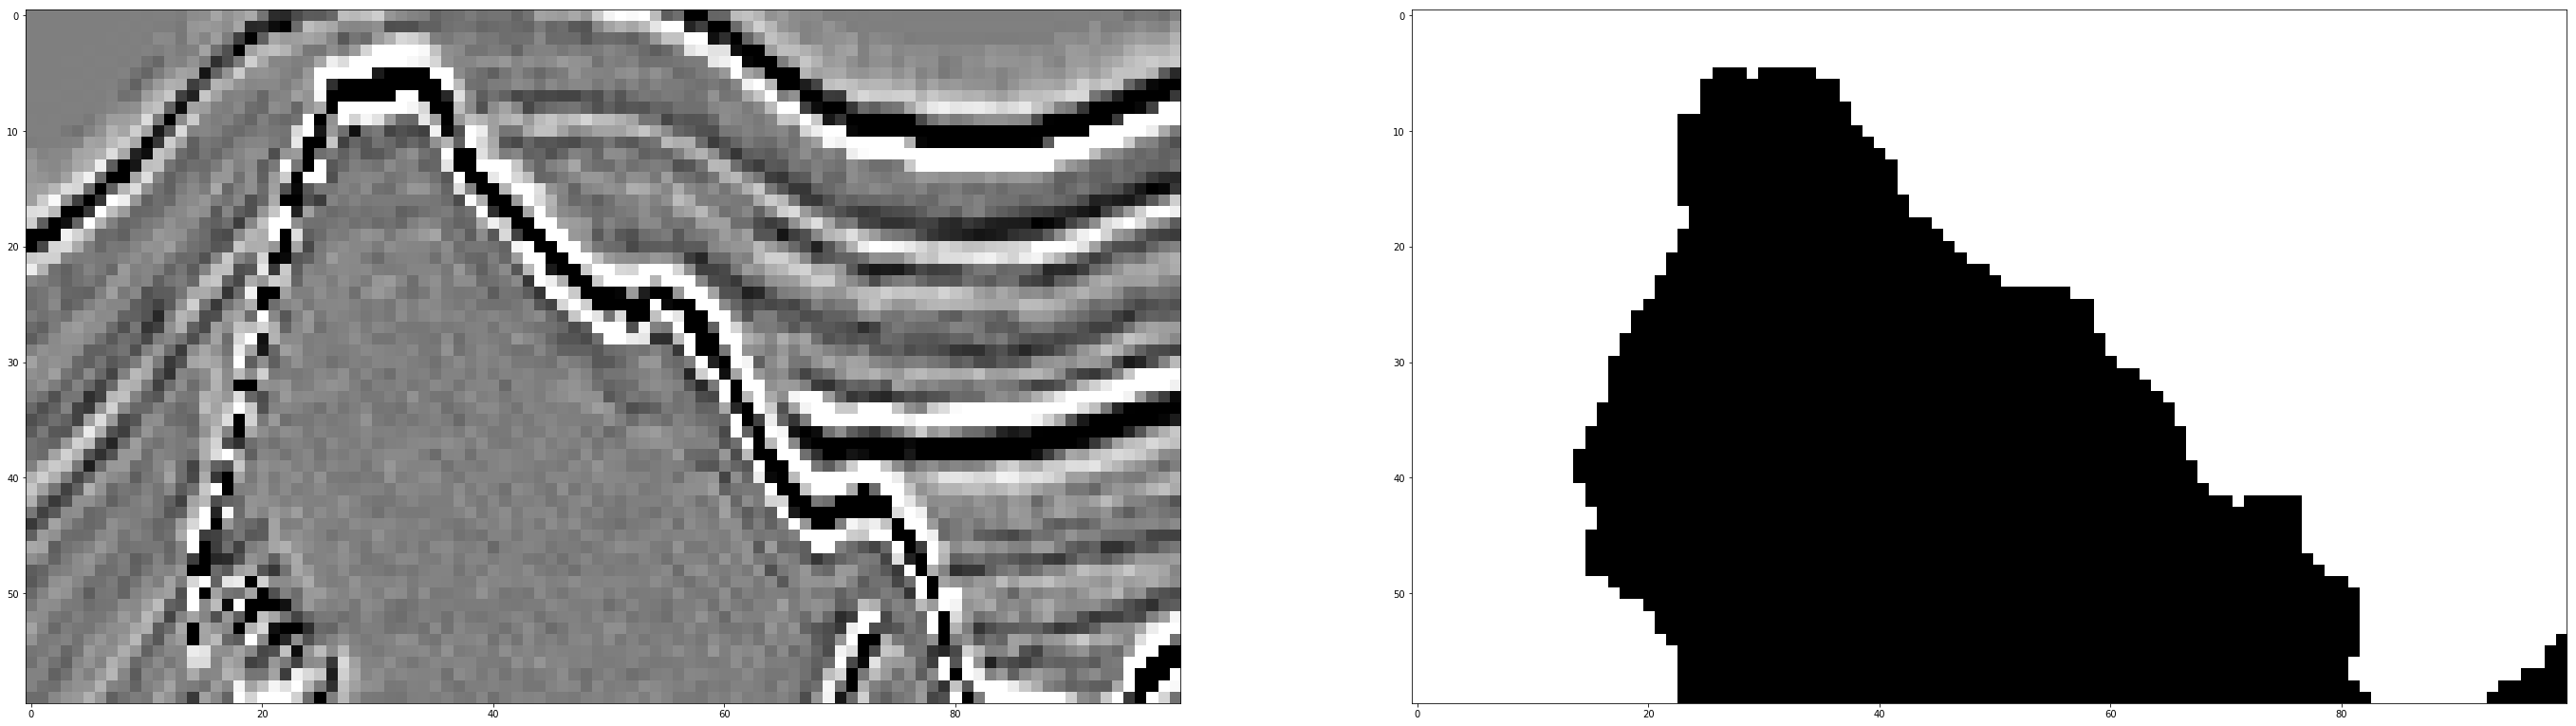

In [4]:
# zoom-in QC
fig, axs = plt.subplots(1, 2, figsize=(48,48), facecolor='w', edgecolor='k')

axs[0].imshow(image_sgyin[20:80,0,120:220], cmap='gray_r', vmin=-255, vmax=255)
axs[1].imshow(label_sgyin[20:80,0,120:220], cmap='gray_r', vmin=0, vmax=1)

As can be seen from the above zoom-in comparison, though interpolated salt labels are overally good and match with the seismic image, they are however not accurate in details. This will impact the CNN prediction later. But for now, I will just use whatever available to use.

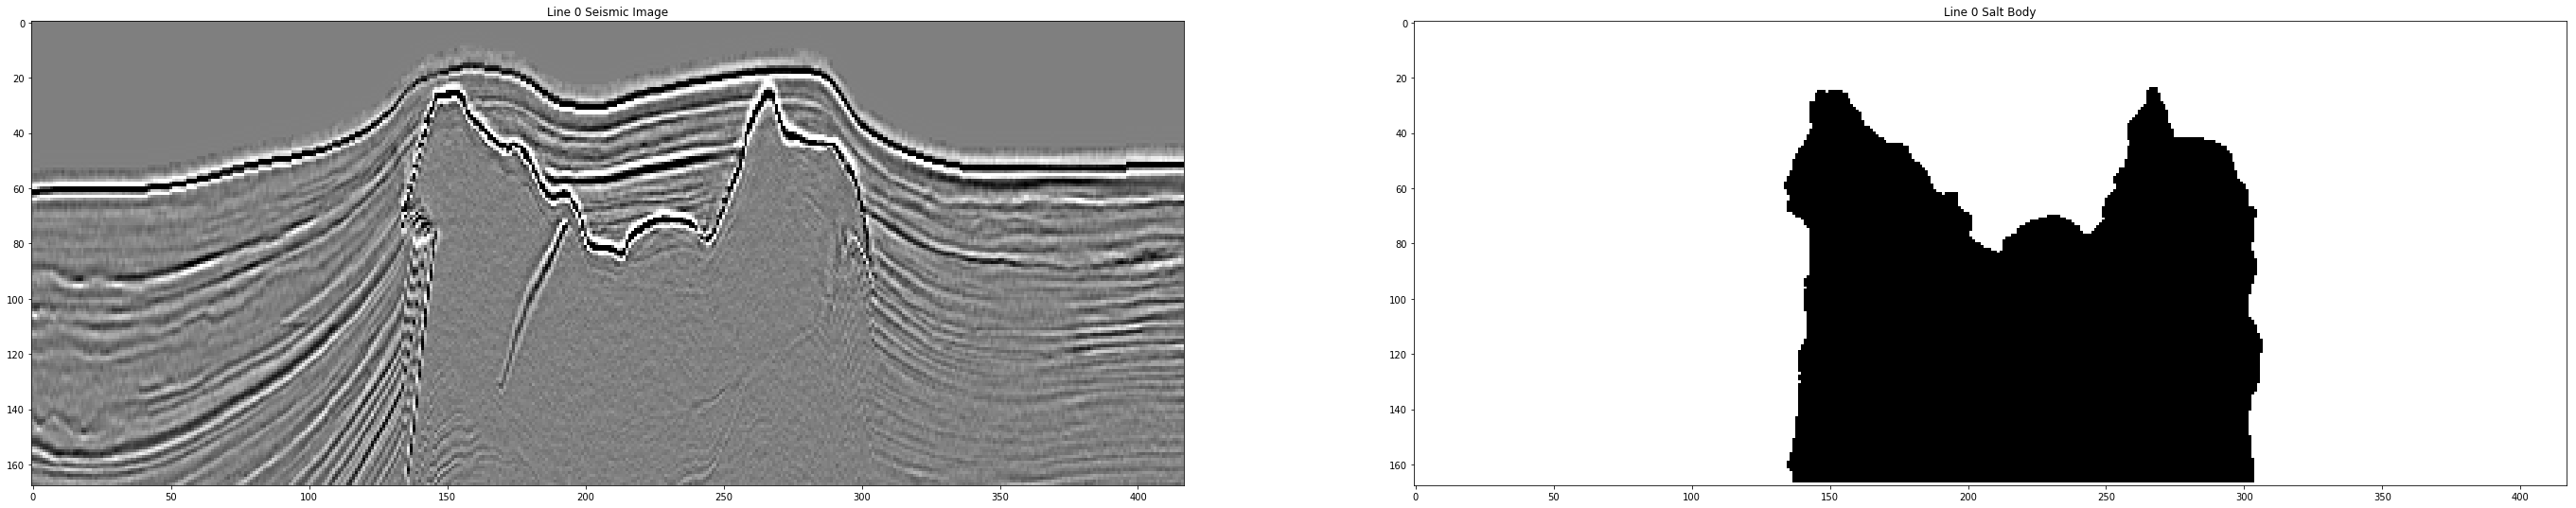

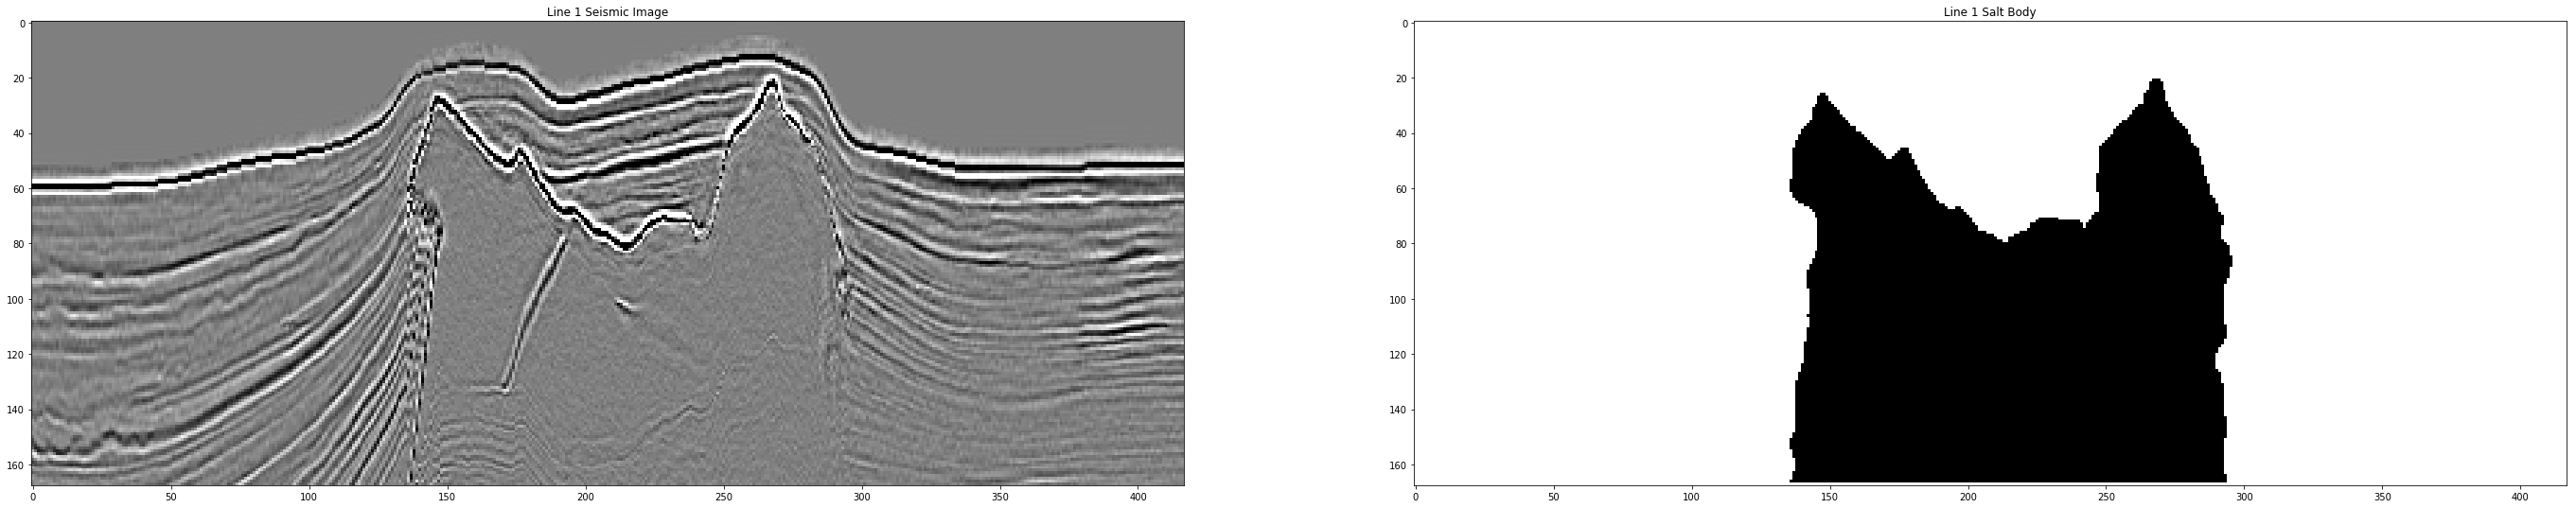

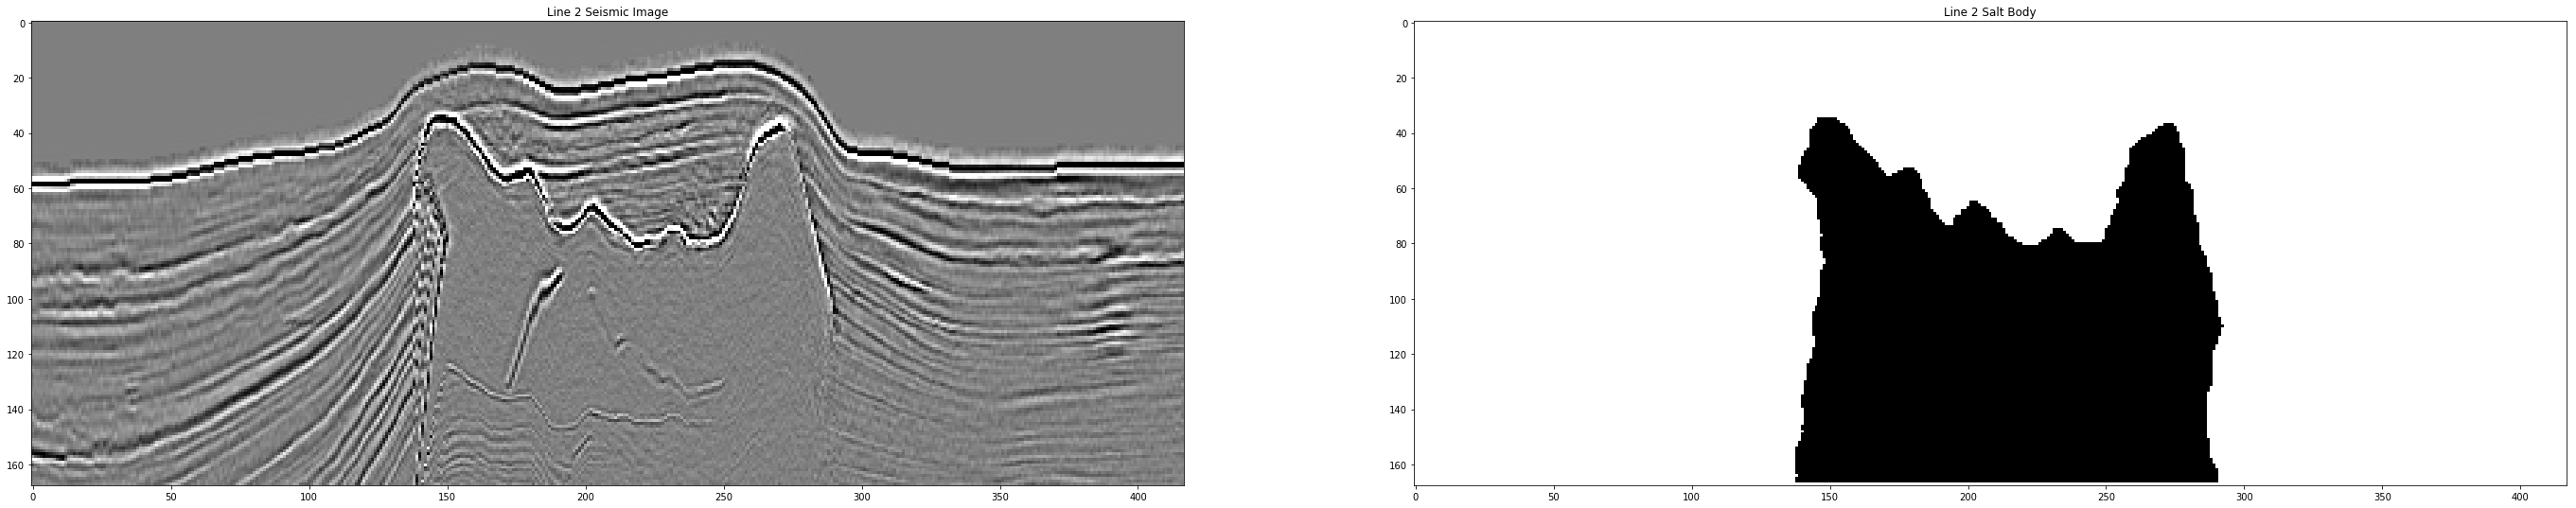

In [5]:
# get an overview of all 3 inlines
plt.rcParams.update({'font.size':22})

for il in range(3):
    fig, axs = plt.subplots(1, 2, figsize=(48,24), facecolor='w', edgecolor='k')

    axs[0].imshow(image_sgyin[:,il,:], cmap='gray_r', vmin=-255, vmax=255)
    axs[0].set_title("Line {} Seismic Image".format(il))
    axs[1].imshow(label_sgyin[:,il,:], cmap='gray_r', vmin=0, vmax=1)
    axs[1].set_title("Line {} Salt Body".format(il))


## 2. Raw data QC and data transformation <a id="cell_2"></a>

In [6]:
# use first Inline as test, to check image size
im0 = image_sgyin[:,0,:]
im0.shape

(168, 417)

The raw image dimension of (168, 417) is too small. Let's try some upsampling on the image, which later will be cropped into small pieces in 101x101 pixel for CNN exercise.

First, let's see how much zoom-in we will need to get an image with ~1000x1000 in dimension. That means, after 101x101 cropping, we can get roughly a few hundred images for each line. Zoom-in too much will cause the 101x101 cropping for CNN meaningless.

In [8]:
# zoom in scipy works outta package for our purpose
# http://scipy.github.io/devdocs/generated/scipy.ndimage.zoom.html#scipy.ndimage.zoom
# 'order' refers to the order of the spline interpolation, range 0-5

from scipy.ndimage import zoom
zoom(im0, 3, order=3).shape, zoom(im0, 5, order=3).shape, zoom(im0, 7, order=3).shape, zoom(im0, 21, order=3).shape

((504, 1251), (840, 2085), (1176, 2919), (3528, 8757))

It looks like, dimension-wise, zoom=7 is a good choice.

We would also like to add some interpolation to improve the image quality after up-sampling. The spline interplation parameters we compare will be 3 & 5. **Order = 3** is good enough for our purpose.

Text(0.5, 1.0, 'zoom factor=7, spline interpolation, order=5')

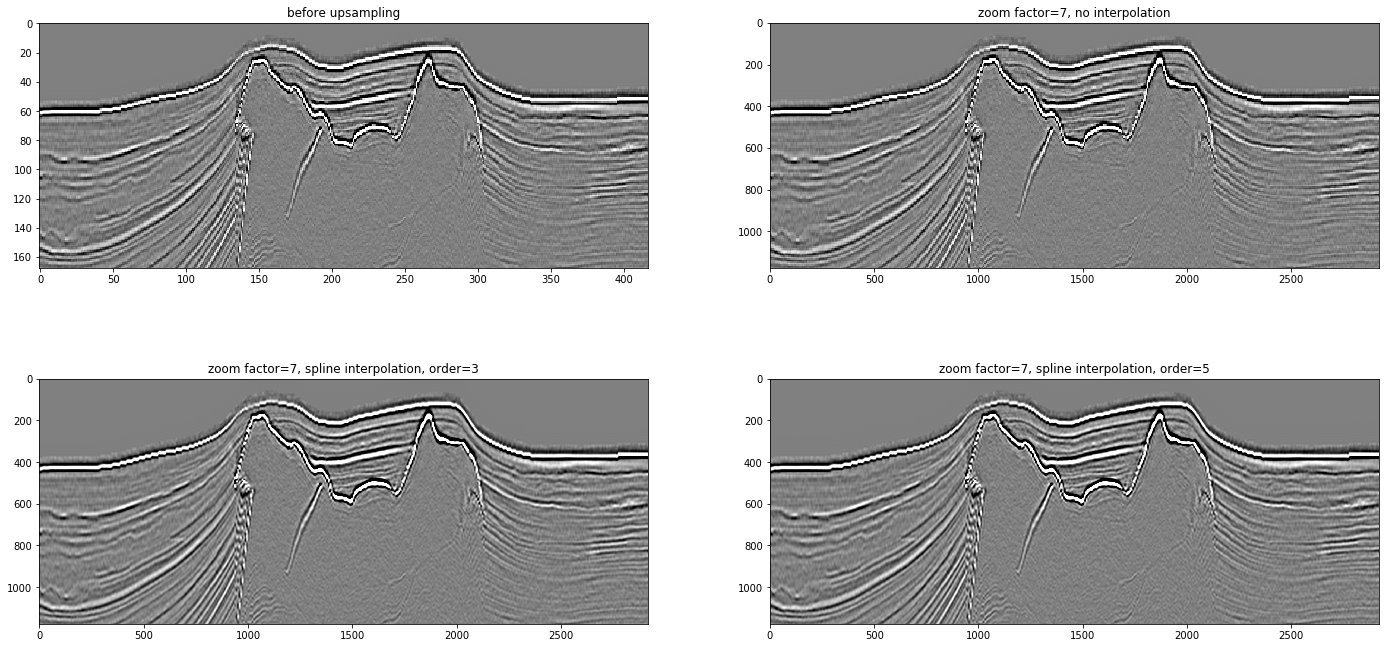

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(24,12), facecolor='w', edgecolor='k')

axs[0, 0].imshow(im0, cmap='gray', vmin=-255, vmax=255)
axs[0, 0].set_title("before upsampling")
axs[0, 1].imshow(zoom(im0, 7, order=0), cmap='gray', vmin=-255, vmax=255)
axs[0, 1].set_title("zoom factor=7, no interpolation")
#axs[1, 0].imshow(im0_upsamp, cmap='gray', vmin=-255, vmax=255)
axs[1, 0].imshow(zoom(im0, 7, order=3), cmap='gray', vmin=-255, vmax=255)
axs[1, 0].set_title("zoom factor=7, spline interpolation, order=3")
axs[1, 1].imshow(zoom(im0, 7, order=5), cmap='gray', vmin=-255, vmax=255)
axs[1, 1].set_title("zoom factor=7, spline interpolation, order=5")

## 3. Crop into small images, each of size 101x101 <a id="cell_3"></a>

By upsampling to seven times original size, we can obtain over 300 images if cropped with 101x101.

In [10]:
im0_upsamp = zoom(im0, 7, order=3)   # upsampling with zoom=7, interpolation spline order=3
print("Image shape after up-sampling: {}x{}".format(im0_upsamp.shape[0], im0_upsamp.shape[0]))
print("Number of splitted images:", im0_upsamp.shape[0]*im0_upsamp.shape[1]//101//101 )

Image shape after up-sampling: 1176x1176
Number of splitted images: 336


Crop image to interger multiples of 101

In [11]:
[n_row, n_col] = np.array(im0_upsamp.shape)//101*101

# start from the bottom in order to avoid too many blank at the shallow
im0_prp = im0_upsamp[-n_row:, :n_col]
im0_prp.shape

(1111, 2828)

In [12]:
# split 2D array into blocks of size 101x101
# https://stackoverflow.com/questions/16856788/slice-2d-array-into-smaller-2d-arrays
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    
    blocks = arr.reshape(h//nrows, nrows, -1, ncols).swapaxes(1,2).reshape(-1, nrows, ncols)
   
    return (blocks)

Following example is just to showcase the split works.

In [13]:
tmp = blockshaped(im0_prp, 101, 101)
tmp.shape

(308, 101, 101)

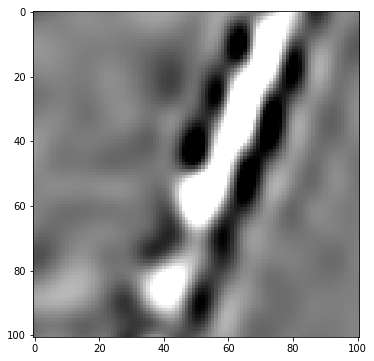

In [14]:
# pick one 101x101 picture for test QC
plt.figure(num=None, figsize=(12,6))
plt.imshow(tmp[101], cmap='gray', vmin=-255, vmax=255)

## 4. Save cropped image as numpy array, for CNN test <a id="cell_4"></a>

In [15]:
for sgy, file in zip([image_sgyin, label_sgyin], ['images', 'labels']):
    
    ims = np.array([sgy[:,i,:] for i in range(3)])
    ims_upsamp = [zoom(im, 7, order=3) for im in ims]
    ims_prp = [im[-n_row:, :n_col] for im in ims_upsamp]
    ims_crop = np.array([blockshaped(im, 101, 101) for im in ims_prp])
    ims_crop = ims_crop.reshape(ims_crop.shape[0]*ims_crop.shape[1], ims_crop.shape[2], ims_crop.shape[3])
    print('The dimensions of the generated/cropped {} array is {}'.format(file, ims_crop.shape))
    np.save(file, ims_crop)
    

The dimensions of the generated/cropped images array is (924, 101, 101)
The dimensions of the generated/cropped labels array is (924, 101, 101)


## 5. Read the data back to QC <a id="cell_5"></a>

In [16]:
labels = np.load('labels.npy')
images = np.load('images.npy')

print("image shape:", images.shape)
print("label shape:", labels.shape)

image shape: (924, 101, 101)
label shape: (924, 101, 101)


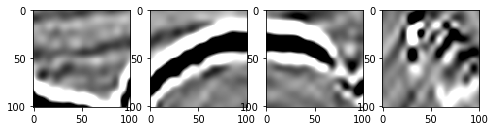

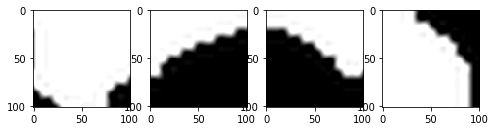

In [17]:
# QC the generated data frame
for readbk, [vmin, vmax] in zip([images, labels], [[-255, 255], [0, 1]]):

    fig, axs = plt.subplots(1, 4, figsize=(8,4))

    axs[0].imshow(readbk[126], cmap='gray_r', vmin=vmin, vmax=vmax)
    axs[1].imshow(readbk[127], cmap='gray_r', vmin=vmin, vmax=vmax)
    axs[2].imshow(readbk[128], cmap='gray_r', vmin=vmin, vmax=vmax)
    axs[3].imshow(readbk[121], cmap='gray_r', vmin=vmin, vmax=vmax)

Image splitting seems to work fine. Next, we can start the fun part with Deep Convolutional Neural Networks to interpret salt body!